## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [3]:
import pandas as pd

In [4]:
import io

In [5]:
# Загрузка данных
from google.colab import files
uploaded = files.upload()
data = pd.read_csv(io.StringIO(uploaded['data.csv'].decode('utf-8'))) # преобразование байтового объекта в строковый объект

Saving data.csv to data.csv


In [10]:
# Вывод первых 10 строк для просмотра
print(data.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset=['Age']), .reset_index(drop=True)`*

In [11]:
# Удаление строк с неизвестным возрастом
data = data.dropna(subset=['Age'])

# Перенумерация строк
data = data.reset_index(drop=True)

# Вывод первых 10 строк для просмотра
print(data.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            7         0       1   
6            8         0       3   
7            9         1       3   
8           10         1       2   
9           11         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                            McCarthy, Mr. Timothy J    male  54.0      0   
6                     Palsson, Master. Gosta Leonard    male   2

## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [39]:
%matplotlib inline 
# дозволяє відображати діаграми, створені за допомогою пакета matplotlib, безпосередньо під коміркою, яка їх створила.
import matplotlib.pyplot as plt

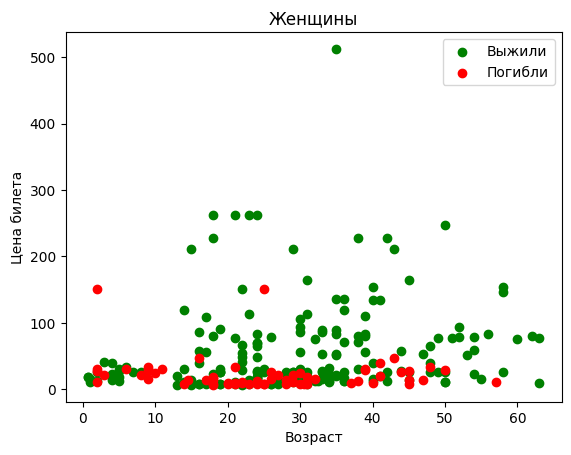

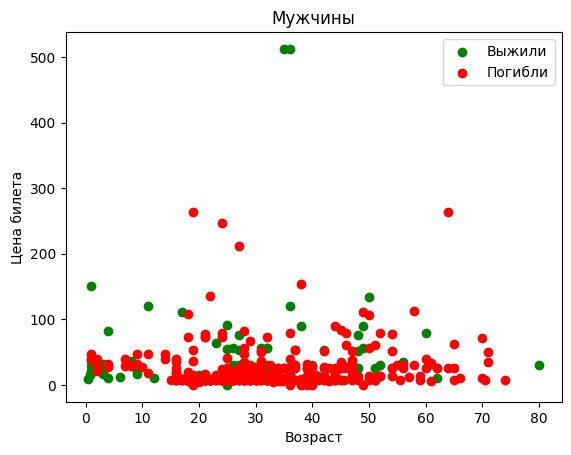

In [37]:
# График для женщин
female = data[data['Sex'] == 'female']
survived_female = female[female['Survived'] == 1]
died_female = female[female['Survived'] == 0]
plt.scatter(survived_female['Age'], survived_female['Fare'], c='g', label='Выжили')
plt.scatter(died_female['Age'], died_female['Fare'], c='r', label='Погибли')
plt.xlabel('Возраст')
plt.ylabel('Цена билета')
plt.title('Женщины')
plt.legend()
plt.show()

# График для мужчин
male = data[data['Sex'] == 'male']
survived_male = male[male['Survived'] == 1]
died_male = male[male['Survived'] == 0]
plt.scatter(survived_male['Age'], survived_male['Fare'], c='g', label='Выжили')
plt.scatter(died_male['Age'], died_male['Fare'], c='r', label='Погибли')
plt.xlabel('Возраст')
plt.ylabel('Цена билета')
plt.title('Мужчины')
plt.legend()
plt.show()

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [29]:
def distance(a,b):
    d = 0
    d += abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [40]:
import numpy as np
import tqdm 
# створення індикаторів виконання (прогрес)

In [31]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [34]:
accuracy = 0
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    accuracy += row['Survived'] == myKNeighborsClassifier(data, 5, idx)
print(accuracy/data.shape[0])

100%|██████████| 714/714 [03:01<00:00,  3.93it/s]

0.726890756302521


Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

In [32]:
# Импортируем необходимые библиотеки
import numpy as np
import tqdm

# Инициализируем переменные для лучшей точности и соответствующего значения k
best_accuracy = 0
best_k = 0

# Перебираем k от 1 до 20
for k in range(1, 21):
    # # Вычисляем точность классификации с использованием myKNeighborsClassifier для каждого объекта выборки
    # и сохраняем ее в переменную accuracy
    accuracy = (data['Survived'] == np.array([myKNeighborsClassifier(data, k, i) for i in range(len(data))])).sum() / len(data)
    if accuracy > best_accuracy:
      # # Если текущая точность больше лучшей, то обновляем лучшую точность и соответствующее значение k
        best_accuracy = accuracy
        best_k = k

# Выводим наилучшее значение точности и соответствующее значение k
print("Best accuracy = {}, Best K = {}".format(best_accuracy, best_k))


Best accuracy = 0.7366946778711485, Best K = 9


## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [33]:
# Функция для вычисления отступа (margin)
# learnData - данные для обучения модели
# K - количество соседей
# passengerIndexForPrediction - индекс пассажира, для которого вычисляется отступ
def calcMargin(learnData, K, passengerIndexForPrediction):
  # Создание массива расстояний между пассажиром и остальными
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    # Проход по всем записям данных обучающей выборки
    for idx, row in learnData.iterrows():
      # Если запись не соответствует индексу пассажира для предсказания, то
      # добавляем расстояние между пассажирами и выживаемость рассматриваемого пассажира в массив расстояний
        if idx != passengerIndexForPrediction:  # LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    # Сортируем расстояния по возрастанию
    dists = sorted(dists, key=lambda pair: pair[0])
    # Вычисляем количество эталонных и шумовых объектов
    etalonCount = 0
    noiseCount = 0
    margin = 0
    for i in range(K):
        margin += dists[i][0]
        if dists[i][1] == 1:
            etalonCount += 1
        else:
            noiseCount += 1
    # Возвращаем отступ, количество эталонных и шумовых объектов
    return (margin/K, etalonCount/K, noiseCount/K)

# Создание массива отступов для всех пассажиров в данных
margins = np.zeros((data.shape[0], 3))
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    margins[idx] = calcMargin(data, 5, idx)

# Сортировка пассажиров по возрастанию отступа
sortedMargins = sorted(margins, key=lambda triple: triple[0])

# Вывод 5 пассажиров с минимальным отступом
print("Min margin outliers:")
for i in range(5):
    print(sortedMargins[i])
# Вывод 5 пассажиров с максимальным отступом
print("Max margin exemplars:")
for i in range(1, 6):
    print(sortedMargins[-i])

100%|██████████| 714/714 [03:09<00:00,  3.77it/s]

Min margin outliers:
[0.045 0.6   0.4  ]
[0.045 0.4   0.6  ]
[0.045 0.6   0.4  ]
[0.05668 0.6     0.4    ]
[0.06668 0.2     0.8    ]
Max margin exemplars:
[161.92252   1.        0.     ]
[161.52252   1.        0.     ]
[161.12252   1.        0.     ]
[44.82084  0.8      0.2    ]
[33.73082  0.6      0.4    ]
